# UMLs

![UML Diagram](data_summary.png)

![UML Diagram2](model_uml.png)


# Import Packages

In [1]:
pip install git+https://github.com/crimson206/DeepLearningDevelopment@0.1.6

  Cloning https://github.com/crimson206/DeepLearningDevelopment (to revision 0.1.6) to /tmp/pip-req-build-e2va0qup
  Running command git clone --filter=blob:none --quiet https://github.com/crimson206/DeepLearningDevelopment /tmp/pip-req-build-e2va0qup
  Running command git checkout -q c85515a58cda682c53f623b1f7864ad6c52a89dd
  Resolved https://github.com/crimson206/DeepLearningDevelopment to commit c85515a58cda682c53f623b1f7864ad6c52a89dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from CrimsonDeepLearning.transformers.models.MultiEmbeddingTransformers import MultiEmbeddingTransformerBuilder
from CrimsonDeepLearning.transformers.headers.Regressionheads import RegressionHead
from CrimsonDeepLearning.transformers.models.Crimsonformer import Crimsonformer
from CrimsonDeepLearning.utils.data import dict_to_device
from CrimsonDeepLearning.utils.losses import FlattenLoss, NanProofLoss, combined_loss
from CrimsonDeepLearning.visualization.displays import display_progress
from CrimsonDeepLearning.visualization.loggers import LossLogger

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

device = "cuda" if torch.cuda.is_available() else "cpu"

# Definition of the Prolbem
    From RNA structure, predict the reactivity values
    
    Please check the link

    https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding

# Data

For this demonstration, I use only a part of the data.
You can obtain the (unprocessed) whole data from the kaggle competition.

## Understanding Data

In [3]:
data = pd.read_parquet("please visit the link for data")

data.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206,structure,sequence_ext,seq_len,fold
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,.....((((((.....)))))).....(.(((((..((((((((((...,BBBEEGADGJGBEBKECFCLICEEEEEGEJJADJEKAADJJJDGJG...,170,1
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,((...((((((.....)))))).....))(((((..((((((((((...,AABEEGADGJGBEBKECFCLICEEEEEIIJJADJEKAADJJJDGJG...,170,2
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,.....((((((.....)))))).......(((((..((((((((((...,BBBEEGADGJGBEBKECFCLICEEEEEHKJJADJEKAADJJJDGJG...,170,0
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,.....((((((.....))))))........((((..((((((((((...,BBBEEGADGJGBEBKECFCLICEEEEEHBEJADJEKAADJJJDGJG...,170,2
5,aa948762535f,GGGAACGACUCGAGUAGAGUCGAAAAACGCUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,14018,3.219,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,.....((((((.....))))))......(.((((..((((((((((...,BBBEEGADGJGBEBKECFCLICEEEEEHAHJADJEKAADJJJDGJG...,170,1


- Sequence:
  The RNA is represented as a sequence of 4 letters (G, U, A, C).

- Structure:
  The 3D structure information of the Sequence is represented by 3 symbols. You can see examples by searching for RNA structure images on Google. 
  [Google Image Search for RNA Structure](https://www.google.com/search?sca_esv=587728493&q=rna+structure&tbm=isch&source=lnms&sa=X&ved=2ahUKEwj35aPopvaCAxWXhf0HHS_vCRUQ0pQJegQIDRAB&biw=1745&bih=857&dpr=1.1)

- Experiment Map:
  The reactivity values were measured with different experiments. In this example, we have only two (2A3, DMS).


In [4]:
# hidden code

print("Sequence example:")
print(data["sequence"].iloc[0])
print("\nStructre example:")
print(data["structure"].iloc[0])

Sequence example:
GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC

Structre example:
.....((((((.....)))))).....(.(((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))...)....((((((((....)))))))).....................


- Reactivity:\
    It is the target value.\
    The reactivity of a nucleotide in RNA refers to its tendency to interact with other molecules or participate in chemical reactions.

- Signal To Noise, Reads, Error\
    They are related to the reactivity measurement accuracy.


In [5]:
# hidden code

reactivity_cols = [col for col in data.columns if "reactivity_0" in col]
data[reactivity_cols].values[0]

print("Sequence example:")
print(data["sequence"].iloc[0])
print("\nStructre example:")
print(data["structure"].iloc[0])

Sequence example:
GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC

Structre example:
.....((((((.....)))))).....(.(((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))...)....((((((((....)))))))).....................


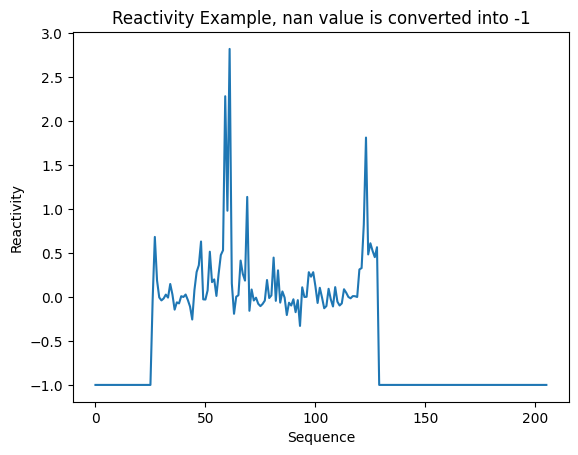

In [6]:

reactivity_cols = [col for col in data.columns if "reactivity_0" in col]

reactivity_example = data[reactivity_cols].values[0]
reactivity_example[np.isnan(reactivity_example)] = -1

plt.plot(reactivity_example)
plt.title("Reactivity Example, nan value is converted into -1")
plt.ylabel("Reactivity")
plt.xlabel("Sequence")
plt.show()

## Data Process

1. The target value is the reactivity values.\

    - In train data,\
        : sequence, reactivity, experiment_map + signal_to_noise, reads, error.

    - In test data,\
        : sequence, reactivity, experiment_map.

2. Processed data

    - Structure\
        : One can extract structures from sequences, so I added this to both data.
    - Nan_position\
        : The sequence positions with nan values
    - Front_posotion\
        : The distance from the start of a RNA
    - Back_posotion\
        : The distance from the end of a RNA

3. Data Usage

    - Input data\
        : sequence, structure, experiment Map

    - Main Output\
        : reactivity

    - Sub Outputs:\
        : nan_position, signal_to_noise, reads, error

* The reactivity values are dependent on the sub outputs values, so we'd better use the values,\

    but, we can't use the value for the interference.\

    Therefore, we use the data for auxiliary tasks.



4. Processing grouped by sequence length

    - The data is processed respectively grouped by the sequence length

        - We don't need to use attention mask and padding.
        
        - It enhance the speed of training and accuracy.

5. Data Structure

    List[Dictionary[key]:Tensor],

    where Dictionary[key].shape is (n_batch, n_seq) or (n_batch)


The process functions are in data_process.py. You can read if you are interested in.

In [7]:
from data_process import process_data

processed_data_in_seq_len = {}

seq_lens = data["seq_len"].unique()

data_size_per_seqlen = 1000
for seq_len in seq_lens:
    data_temp = data[data["seq_len"]==seq_len]
    processed_data_in_seq_len[seq_len] = process_data(data_temp.iloc[:data_size_per_seqlen], seq_len=seq_len, max_len=seq_len)

processing seq_len 170


Tokenizing sequences: 100%|██████████| 1000/1000 [00:00<00:00, 131314.11it/s]


processing seq_len 177


Tokenizing sequences: 100%|██████████| 1000/1000 [00:00<00:00, 124752.51it/s]


processing seq_len 115


Tokenizing sequences: 100%|██████████| 1000/1000 [00:00<00:00, 168880.01it/s]


processing seq_len 155


Tokenizing sequences: 100%|██████████| 1000/1000 [00:00<00:00, 135191.10it/s]


processing seq_len 206


Tokenizing sequences: 100%|██████████| 1000/1000 [00:00<00:00, 110164.79it/s]


6. Folds
    - In the FoldHolder, we initialize an array np.randint(0, k_fold, (n_data)).
    - Using the array as indexes, we can get different folds.

In [8]:
tensor_list = []

batch_size = 32
for seq_len in seq_lens:
    process_data_temp = processed_data_in_seq_len[seq_len]
    n_data = len(process_data_temp["sequence_ids"])

    tensor_dict = {}

    start_index = 0
    end_index = start_index + batch_size
    while end_index < n_data:
        for key, value in process_data_temp.items():
            tensor_dict[key] = value[start_index:end_index]
        tensor_dict = dict_to_device(tensor_dict, device)
        tensor_list.append(tensor_dict)

        start_index += batch_size
        end_index = start_index + batch_size

class FoldHolder():
    def __init__(self, tensor_list, k_folds, seed):
        self.tensor_array = tensor_list

        n_data = len(tensor_list)
        self.folds = self._set_folds(
            n_data=n_data,
            k_folds=k_folds,
            seed=seed
        )
        self._reference_idx = np.arange(n_data)

    def get_fold(self, fold):
        train_mask = np.array(self.folds != fold)
        val_mask = np.array(self.folds == fold)

        train_idx = self._reference_idx[train_mask]
        val_idx = self._reference_idx[val_mask]

        train_list = [tensor_list[i] for i in train_idx]
        val_list = [tensor_list[i] for i in val_idx]

        return train_list, val_list

    def _set_folds(self, n_data, k_folds, seed):
        np.random.seed = seed
        folds = np.random.randint(0, k_folds, (n_data))
        return folds

fold_holder = FoldHolder(tensor_list=np.array(tensor_list), k_folds=4, seed=42)
train_list, val_list = fold_holder.get_fold(1)

len(train_list), len(val_list)

(116, 39)

## Model

1. Multi Positional Encoding.
    - We device the embedding space into two, and each half is used for front or back position id.
    - At the end of a RNA, the back positional information [... 2, 1, 0] is more important than the front positional information [0, 1, 2 ...].
    - For sequences with different seq_lens, my embedding can give both positional information.

2. Multi Categorical Embedding.
    - We have 3 different categorical informations.
    - Therefore, we embed them respectively, and concatenate them.
    - For the more important parameter, we can assign more embedding dimension.

3. Encoder.
    - We can choose a model from the transformers library to use its encoder.

For the implementation codes, visit my DeepLearning library.
    - https://github.com/crimson206/DeepLearningDevelopment

In [39]:
import random
import os


In [45]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [52]:
builder = MultiEmbeddingTransformerBuilder()

seed_everything(seed=12)

model_name = 'microsoft/mpnet-base'
transformer_config = {
    'hidden_size': 256,
    'num_hidden_layers': 12,
    'num_attention_heads': 4,
    'intermediate_size': 756,
    'attention_probs_dropout_prob': 0.1,
    'hidden_dropout_prob': 0.1,
    'output_hidden_states': True
}

multi_emb_transformer_input_frame = {
    'pos_max_lengths': [500, 500], # Front position, Back position
    'pos_embedding_dims': [128, 128],
    'categorical_sizes': [5, 4, 3], # Sequence, Structure, Experiment_id
    'categorical_emb_dims': [128, 64, 64],
    'skip_emb_size': 0,
    'continuous_feature_in': 0,
    'continuous_feature_out': 0,
}

multi_emb_former = builder.build(
    model_name=model_name, 
    config=transformer_config, 
    multi_emb_transformer_input_frame=multi_emb_transformer_input_frame,
)

d_emb = transformer_config["hidden_size"]

4. Regression Heads and Losses
    - We want to implement many tasks and output shapes.
    - For the cleaner implementation, we implement them in lists together.
    - The loss weight can be easily set and editted using the variable loss_weight.

In [53]:
regression_heads = [
    RegressionHead(input_size=d_emb, output_size=2), # nan_position prediction
    RegressionHead(input_size=d_emb, output_size=2, pool=True), # signal_to_noise, reads prediction
    RegressionHead(input_size=d_emb, output_size=1), # error prediction
    RegressionHead(input_size=d_emb, output_size=1) # reactivity prediction
]

crimsonformer = Crimsonformer(
    multi_embedding_transformer=multi_emb_former,
    regression_heads=regression_heads
).to(device)

criterions = [
    FlattenLoss(nn.CrossEntropyLoss()),
    NanProofLoss(nn.L1Loss()),
    NanProofLoss(nn.L1Loss()),
    NanProofLoss(nn.L1Loss()),
]

loss_weight = [0.1, 0.1, 0.2, 0.6]

## Training

1. Optimizer and Scheduler
    - Just a normal setup

2. LossLogger
    - We will monitor the losses.
    - We have 2 * 4 losses (tran or validataion * 4 tasks)
    - For the cleaner code, we use LossLogger to collect and process the losses

In [56]:
optimizer = torch.optim.AdamW(crimsonformer.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

train_logger = LossLogger()
val_logger = LossLogger()

3. Load Data from a mini batch
    - We have many different input data, and label data.
    - We encapsulate all the batch data processes using create_batch function.

In [57]:
def create_batch(tensor_dict):

    split_position_ids = [
        tensor_dict["front_position_ids"],
        tensor_dict["back_position_ids"],
    ]

    split_categorical_ids = [
        tensor_dict["sequence_ids"],
        tensor_dict["structure_ids"],
        tensor_dict["experiment_ids"],
    ]

    labels = [
        tensor_dict["nan_position"],
        torch.stack([tensor_dict["signal_to_noise_log"], tensor_dict["reads_log"]], dim=-1),
        tensor_dict["error"],
        tensor_dict["reactivity"],
    ]

    batch = {
        "position":split_position_ids,
        "category":split_categorical_ids,
        "label":labels
    }

    return batch

4. Encapsulate the train(validation) loop

    - Simplify the training process by defining the do_step function.

    - It includes only 3 functionalities

        - training or validation

        - logger updating
        
        - process monitoring

In [58]:
def do_step(model, tensor_list, logger, mode, optimizer=None, scheduler=None):

    if mode=="train":
        model.train()
        np.random.shuffle(train_list)
    elif mode=="validation":
        model.eval()

    np.random.shuffle(tensor_list)
    tqdm_bar = tqdm(tensor_list)

    with torch.set_grad_enabled(mode == "train"):
        for batch in tqdm_bar:
            batch = dict_to_device(batch,  device)
            batch_tensor = create_batch(batch)
            
            split_position_ids = batch_tensor["position"]
            split_categorical_ids = batch_tensor["category"]
            labels = batch_tensor["label"]

            outputs = model.forward(
                split_position_ids=split_position_ids, 
                split_categorical_ids=split_categorical_ids
            )

            if mode=="train":
                labels[3] = labels[3].clamp(-0.5, 2)
            elif mode=="validation":
                outputs[3] = outputs[3].clamp(0, 1)
                labels[3] = labels[3].clamp(0, 1)

            loss, losses_item = combined_loss(criterions=criterions, preds=outputs, labels=labels, loss_weights=loss_weight)
            
            if mode=="train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            logger.batch_step(losses=losses_item, labels=["Nan Loss", "SN Loss", "Error Loss", "Reactivity Loss"])

            tqdm_bar.set_postfix(
                logger.batch_loss_dict,
                refresh=True
            )

    if mode=="train":
        scheduler.step()
    logger.epoch_step()

5. Stepwise Validation

    - If the data is too big, the interval between epochs is too long.\
    
    - We just add a split_list_to_chunks function to devide an epoch\

    - Therefore, we can use the do_step function flexibly, (with part of train_list, but with whole val_list)


6. Visualization

    - The loss histoy is accumulated by loss loggers in a organized form.

    - We make a display_progress function to monitor the progress.

    - Using clear_output, we have the fixed number of plots to monitor the process.
                                                                                                    
    - In this example, I displayed only losses.

    - However, we can visualize the comparison of the outputs and labels, gradients, and so on.
    
    - For each theme, we'd better define different loggers, and different plot functions. (as we use plot_losses and LossLogger in this example)


7. Comparison pred vs label

    - Because of local minimums, the validation loss alone is not reliable.

    - Visualize at lease one comparison between the prediction and the label.

In [59]:
%%capture
!pip install plotly

In [60]:
from IPython import display
import plotly.graph_objects as go

def plot_losses(losses_dict, second_axis_keys=[], title=None, figsize=(600, 400)):
    """
    Plots the loss curves from a dictionary of losses using Plotly, with hover functionality
    and the option to plot some losses on a second y-axis.
    
    Parameters:
    losses_dict (dict): A dictionary where keys are the names of the losses 
                        and values are lists of loss values.
    second_axis_keys (list): List of keys to be plotted on a second y-axis.
    title (str, optional): Title of the plot.
    figsize (tuple): Size of the figure (width, height) in pixels.
    """
    # Create figure with secondary y-axis
    fig = go.Figure()

    # Adding traces for the first y-axis
    for loss_name, loss_values in losses_dict.items():
        if loss_name not in second_axis_keys:
            fig.add_trace(go.Scatter(x=list(range(len(loss_values))), y=loss_values, mode='lines', name=loss_name))

    # Adding traces for the second y-axis
    if second_axis_keys:
        for key in second_axis_keys:
            if key in losses_dict:
                fig.add_trace(go.Scatter(x=list(range(len(losses_dict[key]))), y=losses_dict[key], mode='lines', name=key, yaxis="y2", line=dict(width=2, dash='dash')))

        # Create axis objects
        fig.update_layout(
            yaxis2=dict(
                title="Second Metric",
                overlaying="y",
                side="right"
            )
        )

    # Update layout with figure size
    fig.update_layout(
        title=title or "Loss Curves",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        legend_title="Legend",
        hovermode="closest",
        width=figsize[0],  # Width of the figure
        height=figsize[1]  # Height of the figure
    )

    fig.show()


def display_progress(train_logger, val_logger, second_axis_keys, clear_output=True, fig_size=(600, 400)):
    if clear_output:
        display.clear_output(True)
    plot_losses(train_logger.epoch_losses_dict, second_axis_keys=second_axis_keys , title="Train Losses", figsize=fig_size)
    plot_losses(val_logger.epoch_losses_dict, second_axis_keys=second_axis_keys, title="Validation Losses", figsize=fig_size)

In [61]:
def split_list_to_chunks(input_list, n, shuffle=True):
    if shuffle:                                                                                                         
        np.random.shuffle(input_list)
    chunk_size = len(input_list) // n
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

In [62]:
def predict(model, tensor_list, is_label=True):

    model.eval()
    pred_list = []
    label_list = []

    tqdm_bar = tqdm(tensor_list)
    with torch.no_grad():
        for batch in tqdm_bar:
            batch = dict_to_device(batch, device)
            batch_tensor = create_batch(batch)

            split_position_ids = batch_tensor["position"]
            split_categorical_ids = batch_tensor["category"]

            outputs = model.forward(
                split_position_ids=split_position_ids, 
                split_categorical_ids=split_categorical_ids
            )

            outputs[3] = outputs[3].clamp(0, 1)
            pred_list.append(outputs[3].detach().cpu().numpy())

            if is_label:
                labels = batch_tensor["label"]
                labels[3] = labels[3].clamp(0, 1)
                label_list.append(labels[3].detach().cpu().numpy())

    if is_label:
        return pred_list, label_list
    else:
        return pred_list

In [24]:
def plot_pred_vs_label(pred, label, grid_height, grid_width):
    n = grid_height * grid_width  # Total number of plots
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 5, grid_height * 4))

    for i in range(n):
        row = i // grid_width
        col = i % grid_width

        # Plot on the specified subplot
        axs[row, col].plot(pred[i, :], label='Prediction')
        axs[row, col].plot(label[i, :], label='Label')
        axs[row, col].set_title(f'Graph {i+1}')
        axs[row, col].set_xlabel('Index')
        axs[row, col].set_ylabel('Value')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()


100%|██████████| 39/39 [00:00<00:00, 55.08it/s]


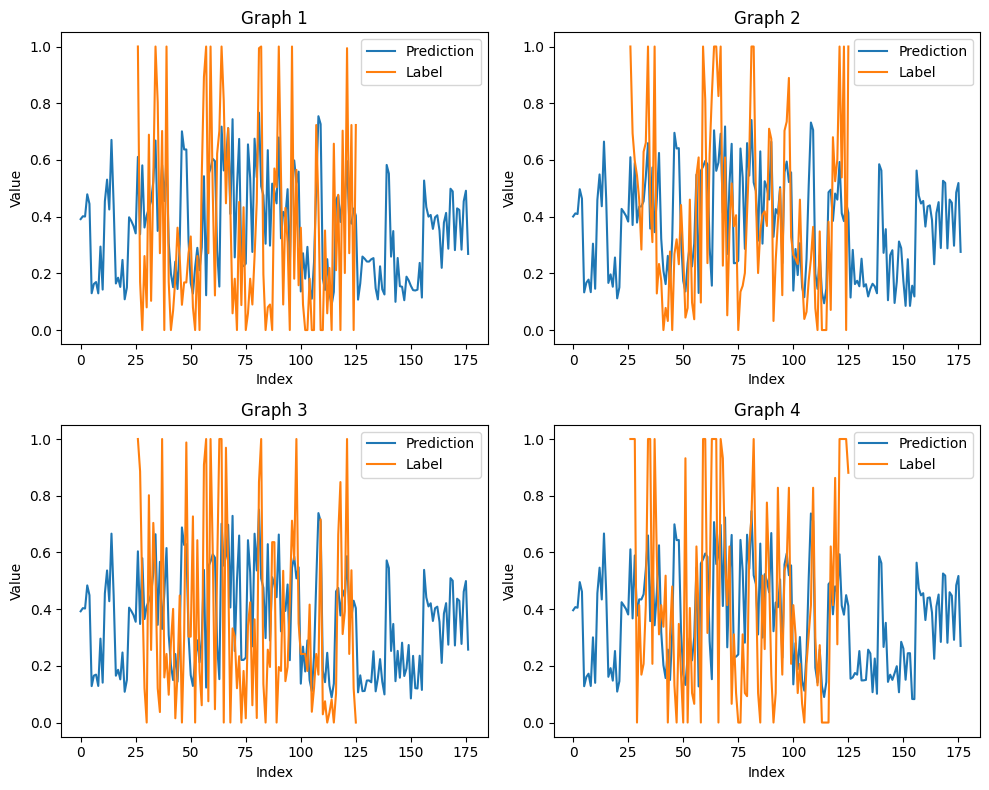

In [63]:
n_epoch = 10

for epoch in range(n_epoch):
    train_list_chunks = split_list_to_chunks(train_list, 3, shuffle=True)
    for i, train_list_chunk in enumerate(train_list_chunks):
        
        print("epoch:", epoch, "\ntrain step:", i)
        do_step(crimsonformer, train_list_chunk, train_logger, "train", optimizer=optimizer, scheduler=scheduler)

        print("epoch:", epoch, "\nvalidation")
        do_step(crimsonformer, val_list, val_logger, "validation", optimizer=None, scheduler=None)

        display_progress(train_logger=train_logger, val_logger=val_logger, second_axis_keys=["Nan Loss", "SN Loss", "Error Loss"], clear_output=True)

        pred_list, label_list = predict(crimsonformer, val_list, is_label=True)
        plot_pred_vs_label(pred_list[0], label_list[0], grid_height=2, grid_width=2)
